In [ ]:
# https://towardsdatascience.com/discover-3d-point-cloud-processing-with-python-6112d9ee38e7


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
file_data_path=".\\data\\sample.xyz"
point_cloud= np.loadtxt(file_data_path,skiprows=1)
mean_Z=np.mean(point_cloud,axis=0)[2]
spatial_query=point_cloud[abs( point_cloud[:,2]-mean_Z)<1]
xyz=spatial_query[:,:3]
rgb=spatial_query[:,3:]

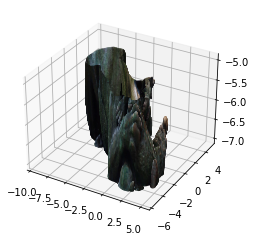

In [3]:
ax = plt.axes(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c = rgb/255, s=0.01)
plt.show()

In [4]:
#print(point_cloud)
#print(point_cloud.shape)
#print(point_cloud[0])
#print(point_cloud[1])
#print(point_cloud[1][3])
#print(point_cloud[:,0])
#xyz=point_cloud[:,:3]
#rgb=point_cloud[:,3:]
#print(xyz)

In [5]:
#print(np.mean(point_cloud,axis=0)[2])
#print(point_cloud[abs( point_cloud[:,2]-mean_Z)<1])
#print(mean_Z)

In [ ]:
# https://medium.com/towards-data-science/how-to-automate-lidar-point-cloud-processing-with-python-a027454a536c

In [8]:
import laspy as lp
dataname=".\\data\\NZ19_Wellington.las"
point_cloud=lp.read(dataname)

In [9]:
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()
factor=160
decimated_points_random = points[::factor]

In [10]:
voxel_size=6
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)

In [11]:
voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]= points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(
    voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)] - np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

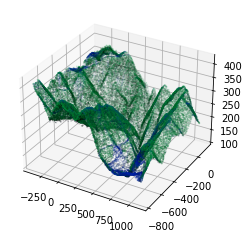

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
decimated_colors = colors[::factor]
ax = plt.axes(projection='3d')
ax.scatter(decimated_points_random[:,0], decimated_points_random[:,1], decimated_points_random[:,2], c = decimated_colors/65535, s=0.01)
plt.show()

In [13]:
np.savetxt(dataname+"_voxel-best_point_%s.txt" % (voxel_size), grid_candidate_center, delimiter=";", fmt="%s")

In [17]:
file_data_path=".\\data\\sample_w_normals.xyz"
point_cloud= np.loadtxt(file_data_path,skiprows=1)


In [18]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(point_cloud[:,3:6]/255)
pointshelp = point_cloud[:,6:9]
pcd.normals = o3d.utility.Vector3dVector(pointshelp)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [19]:
o3d.visualization.draw_geometries([pcd])

In [20]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist

In [21]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [22]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(100000)

In [23]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

TriangleMesh with 87725 points and 99981 triangles.

In [24]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]

In [25]:
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [28]:
output_path=".\\data\\"
o3d.io.write_triangle_mesh(output_path+"bpa_mesh.ply", dec_mesh)
o3d.io.write_triangle_mesh(output_path+"p_mesh_c.ply", p_mesh_crop)

True

In [29]:
#function creation
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [30]:
my_lods = lod_mesh_export(bpa_mesh, [100000,50000,10000,1000,100], ".ply", output_path)

generation of 100 LoD successful


In [31]:
my_lods2 = lod_mesh_export(bpa_mesh, [8000,800,300], ".ply", output_path)

generation of 300 LoD successful


In [32]:
o3d.visualization.draw_geometries([my_lods[100000]])

In [ ]:
# https://medium.com/towards-data-science/how-to-automate-3d-point-cloud-segmentation-and-clustering-with-python-343c9039e4f5

In [2]:
#create paths and load data
import open3d as o3d
input_path=".\\data\\"
dataname="TLS_kitchen.ply"

pcd = o3d.io.read_point_cloud(input_path+dataname)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)
pcd.paint_uniform_color([0.6, 0.6, 0.6])


PointCloud with 511026 points.

In [4]:
o3d.visualization.draw_geometries([pcd]) #Works only outside Jupyter/Colab

In [17]:
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])

Plane equation: 0.22x + 0.71y + 0.67z + 1.14 = 0


PointCloud with 507742 points.

In [18]:
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [113]:
dataname="TLS_kitchen_sample.ply" #planes removed
pcd = o3d.io.read_point_cloud(input_path+dataname)

labels = np.array(pcd.cluster_dbscan(eps=0.05, min_points=10))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

point cloud has 13 clusters


In [52]:
o3d.visualization.draw_geometries([pcd])

In [94]:
#Display one segment
#segment0 = pcd.select_by_index(list(np.where(labels == 0)[0]))
#segment0.paint_uniform_color([0,0,0])
#o3d.visualization.draw_geometries([segment0])


In [121]:
dataname="TLS_kitchen.ply" #planes removed
pcd = o3d.io.read_point_cloud(input_path+dataname)

segment_models={}
segments={}
max_plane_idx=10
rest=pcd
for i in range(max_plane_idx):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
    segments[i]=rest.select_by_index(inliers)
    segments[i].paint_uniform_color(list(colors[:3]))
    rest = rest.select_by_index(inliers, invert=True)
    print("pass",i,"/",max_plane_idx,"done.")

pass 0 / 10 done.
pass 1 / 10 done.
pass 2 / 10 done.
pass 3 / 10 done.
pass 4 / 10 done.
pass 5 / 10 done.
pass 6 / 10 done.
pass 7 / 10 done.
pass 8 / 10 done.
pass 9 / 10 done.


In [122]:
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest])

In [123]:
labels = np.array(rest.cluster_dbscan(eps=0.05, min_points=5))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")

colors = plt.get_cmap("tab10")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
rest.colors = o3d.utility.Vector3dVector(colors[:, :3])



point cloud has 59 clusters


In [124]:
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest])
o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest],zoom=0.3199,front=[0.30159062875123849, 0.94077325609922868, 0.15488309545553303],lookat=[-3.9559999108314514, -0.055000066757202148, -0.27599999308586121],up=[-0.044411423633999815, -0.138726419067636, 0.98753122516983349])
o3d.visualization.draw_geometries([rest])

In [ ]:
#https://medium.com/towards-data-science/guide-to-real-time-visualisation-of-massive-3d-point-clouds-in-python-ea6f00241ee0

# NO PPTK

In [44]:
input_path=".\\data\\"
dataname="2020_Drone_M"
point_cloud=lp.read(input_path+dataname+".las")

In [45]:
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()
colors = np.vstack((point_cloud.red, point_cloud.green, point_cloud.blue)).transpose()

In [46]:
factor=10
decimated_points_random = points[::factor]

In [47]:
# Andi Fix für missing normals
pointshelp = points[:,6:9]
normals = o3d.utility.Vector3dVector(points)

In [48]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors/65535)



In [49]:
pcd.normals = o3d.utility.Vector3dVector(normals)
o3d.visualization.draw_geometries([pcd])

In [50]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,voxel_size=0.40)
o3d.visualization.draw_geometries([voxel_grid])